In [1]:
import ultranest as un
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../system')
import system

In [2]:
paramnames = [
    'sigma', 
    'rp', 
    'rm', 
    'u1', 
    'u2', 
    'ap', 
    'tp', 
    'ep', 
    'pp', 
    'wp', 
    'ip', 
    'am', 
    'tm', 
    'em', 
    'pm', 
    'om', 
    'wm', 
    'im', 
    'mm'
]

t = np.linspace(67.8, 68.8, 1000)

ap = 1.0
t0p = 0.2
ep = 0.2
Pp = 365
wp = 0.0 * np.pi / 180
ip = 90.0 * np.pi / 180

am = 0.007
t0m = -1.2
em = 0.1
Pm = 3
Om = 0.0 * np.pi / 180
wm = 90 * np.pi / 180
im = 90.0 * np.pi / 180
mm = 0.01

rp = 0.05
rm = 0.03
u1 = 0.4
u2 = 0.5

sigma = 0.0001

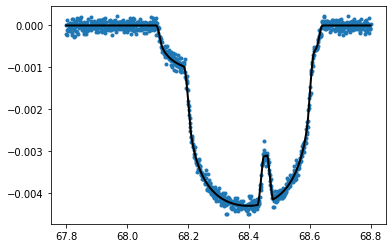

In [3]:
moon = system.moon(rm, am, t0m, em, Pm, Om, wm, im, mm)
planet = system.planet(rp, ap, t0p, ep, Pp, wp, ip)
star = system.star(u1, u2)

sys = system.system(star, planet, moon)
sys.compute(t, grad=True)

lctrue = sys.lightcurve()
y = lctrue + np.random.randn(len(t)) * sigma
plt.plot(t, y, '.')
plt.plot(t, lctrue, color='k', linewidth=2)

In [4]:
# define some prior transforms
from scipy.stats import norm, truncnorm
from types import SimpleNamespace 

uniform = lambda x, low, high: x * (high - low) + low
normal = lambda x, mu, sigma: norm.ppf(x, mu, sigma)
truncated_normal = lambda x, mu, sigma, low, high: truncnorm.ppf(x, low, high, mu, sigma)

def prior_transform(c):
    
    ap = uniform(c[0], 0.8, 1.2)
    tp = normal(c[1], 0.2, 0.1)
    pp = normal(c[2], 365, 0.1)
    wp = truncated_normal(c[3], 0.0, 0.001, -0.2, 0.2)
    ip = truncated_normal(c[4], np.pi/2, 0.001, 0.0, np.pi/2)
    
    am = uniform(c[5], 0.005, 0.01)
    tm = normal(c[6], -1.2, 0.1)
    pm = truncated_normal(c[7], 3.0, 0.1, 0.0, 10.0)
    om = truncated_normal(c[8], 0.0, 0.01, 0.0, 0.1)
    wm = truncated_normal(c[9], np.pi/2, 0.1, 0.0, np.pi)
    im = truncated_normal(c[10], np.pi/2, 0.1, 0.0, np.pi/2)
    mm = uniform(c[11], 0.005, 0.01)
    
    ep = normal(c[12], 0.2, 0.0001)
    em = uniform(c[13], 0.0, 1.0)
    
    q1 = c[14]
    q2 = c[15]
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2 * q2)
    
    rp = truncated_normal(c[16], 0.05, 0.01, 0.15, 0.5)
    rm = truncated_normal(c[17], 0.03, 0.01, 0.0, 0.15)
    
    sigma = truncated_normal(c[18], 0.001, 0.01, 0.0, 0.1)
    
    #ap = 1.0
    #tp = 0.2
    #ep = 0.2
    #pp = 365
    #wp = 0.0 * np.pi / 180
    #ip = 90.0 * np.pi / 180

    #am = 0.007
    #tm = -1.2
    #em = 0.1
    #pm = 3
    #om = 0.0 * np.pi / 180
    #wm = 90 * np.pi / 180
    #im = 90.0 * np.pi / 180
    #mm = 0.01

    #rp = 0.05
    #rm = 0.03
    #u1 = 0.4
    #u2 = 0.5
    
    return [
        sigma, 
        rp, 
        rm, 
        u1, 
        u2, 
        ap, 
        tp, 
        ep, 
        pp, 
        wp, 
        ip, 
        am, 
        tm, 
        em, 
        pm, 
        om, 
        wm, 
        im, 
        mm
    ]

In [7]:
def make_model(args):
    sigma, rp, rm, u1, u2, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm = args
    moon = system.moon(rm, am, tm, em, pm, om, wm, im, mm)
    planet = system.planet(rp, ap, tp, ep, pp, wp, ip)
    star = system.star(u1, u2)
    sys = system.system(star, planet, moon)
    sys.compute(t, grad=False)
    return sys.lightcurve()

def log_like(args):
    
    sigma, rp, rm, u1, u2, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm = args
    moon = system.moon(rm, am, tm, em, pm, om, wm, im, mm)
    planet = system.planet(rp, ap, tp, ep, pp, wp, ip)
    star = system.star(u1, u2)
    sys = system.system(star, planet, moon)
    sys.compute(t, grad=False)
    return sys.loglike(y, sigma)

-195.27513194662572
-895.5447776901044
-698.1186244531732
-1303.0034271501636
-1003.1229830115128
-1598.102710530765
-675.8379154225858
-1525.1067853933523
-1152.3924858091482
-1165.4297502383374
-870.5947507241756
-2002.6330991444972
-573.1578023467922
-216.21494421751737
-525.8217354461341
-741.2030473015293
-235.1817615389128
-284.719365496589
-97.088828893461
-127.16236689772165
-773.3500118497215
-236.56169469055118
-922.870126600345
-490.70183908477765
-506.17353075095315
-1111.6508458432174
-393.68502608383113
-584.9925358832434
-681.4185112364751
-858.8004053648244
-1661.7240948300048
-283.3303528080385
-373.75373657676386
-299.52682193088486
-476.8774477114989
-156.26444726178937
-806.337798642386
-628.1712823902147
-109.44807745024632
-632.2743338651676
-604.0597299446564
-600.134379494675
-690.9502357339798
-1263.3680902834528
-104.72438018435152
-603.150790235536
-140.49201098861337
-598.2565370382877
-913.5472108481518
-949.0618137474657
-494.43796844938055
-1682.313750161

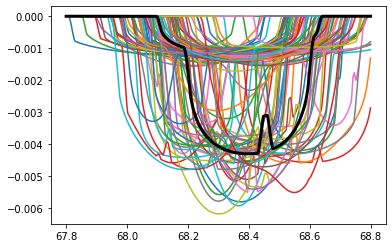

In [8]:
for _ in range(100):
    r = np.random.rand(len(paramnames))
    plt.plot(t, make_model(prior_transform(r)))
    print(log_like(prior_transform(r)))
plt.plot(t, lctrue, color='k', linewidth=3)

In [ ]:
sampler = un.ReactiveNestedSampler(paramnames, log_like, prior_transform)

In [ ]:
%time result = sampler.run(show_status=True, min_num_live_points=50, min_ess=100, max_iters=1000)

In [ ]:
result

In [ ]:
from ultranest.plot import cornerplot

In [ ]:
len(result['samples'])

In [ ]:
for i in np.random.randint(len(result['samples']), size=100):
    plt.plot(t, make_model(result['samples'][i]))